<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [4]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))

In [5]:
data

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net
...,...,...
7595,2014-03-28 13:09:06,webmail.laposte.net
7596,2014-03-28 13:09:07,av.mediapostcommunication.net
7597,2014-03-28 13:09:07,www.google.com
7598,2014-03-28 13:09:07,webmail.laposte.net


In [6]:
data['timestamp'] = data['timestamp'].apply(pd.to_datetime)

In [7]:
t = data['timestamp']

In [8]:
m = data['timestamp'].min()
m

Timestamp('2013-11-15 08:12:07')

In [9]:
m.dayofweek

4

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7600 non-null   datetime64[ns]
 1   site       7600 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 118.9+ KB


**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [11]:
import time


def get_parameters(files,  window_size=10):
    sessions_numbers = []
    targets = []

#     For every .csv file
    for f in files:
        '''Read user data (as DataFrame)'''
        user_data = pd.read_csv(f, low_memory=False)
#         Determine total sessions number:
        sessions_numbers.append(int(np.ceil(user_data.shape[0]/window_size)))
#         Save user name
        targets.append(int(f[-8:-4]))
    return sessions_numbers, targets


def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10, window_size=10):
    """
    The function returns DataFrame of sessions with new features:
    [`session_timespan`,`#unique_sites`, `start_hour`, `day_of_week`]
    """
#     times = []
#     times.append(time.time())

#     ----- Load site_freq
    with open(site_freq_path, 'rb') as site_pkl:
        sites_freq = pickle.load(site_pkl)

#     ----- Determine parameters for a table shape
#     Load .csv files
    files = glob(path_to_csv_files+"/*")
    sessions_numbers, targets = get_parameters(files, window_size)

#     ----- Construct training table (ndarray of zeros) with shape = (session_counter, session_length+1)
    train_data = np.zeros(
        shape=(sum(sessions_numbers), len(feature_names)), dtype='uint')

#     ----- Columns index in feature_names
    feature_index = dict(zip(feature_names, range(len(feature_names))))

#     times.append(time.time())
#     print(times[-1]-times[-2])

#     ----- Fill training table
    line = 0
    for f, sn, t in zip(files, sessions_numbers, targets):
        data = pd.read_csv(f)
        sites_data = np.array([sites_freq[x][0]
                               for x in data['site']] + [0]*(sn*session_length-data.shape[0]))
        ts = pd.to_datetime(data['timestamp'])
        ts_data = np.array(
            (ts - ts.shift(1)).dt.seconds.tolist() + [0]*(sn*session_length-data.shape[0]))
        indecies = np.arange(sn)[:, np.newaxis] * \
            window_size+np.arange(session_length)
        #     Fill sessions
        train_data[line:line+sn, : session_length] = sites_data[indecies]
        #     Fill 'time_diff'
        train_data[line:line+sn, session_length:2*session_length -
                   1] = ts_data[indecies[:, 1:]]
        #     Fill 'start_hour' and 'day_of_week'
        train_data[line:line+sn, feature_index['start_hour']] = ts[::window_size].dt.hour
        train_data[line:line+sn, feature_index['day_of_week']] = ts[::window_size].dt.dayofweek  
        #     Fill 'target'
        train_data[line:line+sn, feature_index['target']] = t

        line += sn

    #     Fill 'session_timespan'
    train_data[:, feature_index['session_timespan']] = np.sum(
        train_data[:, session_length:2*session_length-1], axis=1)
    #     Fill '#unique_sites'
    train_data[:, feature_index['#unique_sites']] = np.array([
        len(set(x[:session_length])-set([0])) for x in train_data])

#     times.append(time.time())
#     print(times[-1]-times[-2])

#     array to DataFrame
    return pd.DataFrame(data=train_data, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [12]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 27.4 ms


In [13]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
3,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3
4,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [14]:
%%time
train_data_10users =  prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 482 ms, sys: 28.4 ms, total: 510 ms
Wall time: 522 ms


In [15]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,60,60,265,39,39,69,160,69,67,67,2,2,283,206,113,1,0,524,1,1132,6,12,4,100
1,72,15,207,574,534,23,37,23,80,85,0,4,1,171,123,0,1,57,120,477,9,12,4,100
2,52,37,23,37,23,23,39,39,69,69,1451,0,1689,0,1,2783,132,29,1,6086,5,12,4,100
3,160,69,69,160,39,69,160,39,39,81,17281,1,0,250,72493,0,262,5148,15,95450,4,14,4,100
4,164,310,164,167,182,161,161,167,61,81,0,1,0,0,0,1,0,4,15,21,7,16,6,100


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [16]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 4.42 s, sys: 314 ms, total: 4.73 s
Wall time: 4.88 s


In [17]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,4,2,1,4,2,25,14,46,1,1,2,66,0,0,49,2,3,25,148,6,12,4,106
1,25,51,51,46,1,2,14,51,4,25,7,2,1,0,0,0,1,0,0,11,7,12,4,106
2,868,902,858,751,902,751,25,85,751,25,0,0,0,1,0,0,1,0,0,2,6,12,4,106
3,902,868,858,751,868,751,858,25,8,2,0,0,1,2,2,0,1,0,0,6,7,12,4,106
4,751,34,34,1,4,2,8,34,42,34,0,1,2,1,2,5,1,2,0,14,7,12,4,106


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [18]:
new_features = ['session_timespan',
                '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [19]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Характеристики признаков

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [20]:
answer1 = np.median(train_data_10users['session_timespan'])
answer1

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [21]:
answer2 = np.median(train_data_10users['day_of_week'])
answer2

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [22]:
answer3 = np.median(train_data_150users['start_hour'])
answer3

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [23]:
answer4 = np.median(train_data_150users['#unique_sites'])
answer4

7.0

Save answers to files

In [24]:
def write_answer(i, answer):
    with open(f"week3_{i}_answer", mode = "w") as file:
        file.write(str(answer))

In [25]:
ans = [answer1, answer2, answer3, answer4]
for i, a in enumerate(ans):
    write_answer(i+1, a)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [26]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [27]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

### <font color = "blue">session_timespan

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

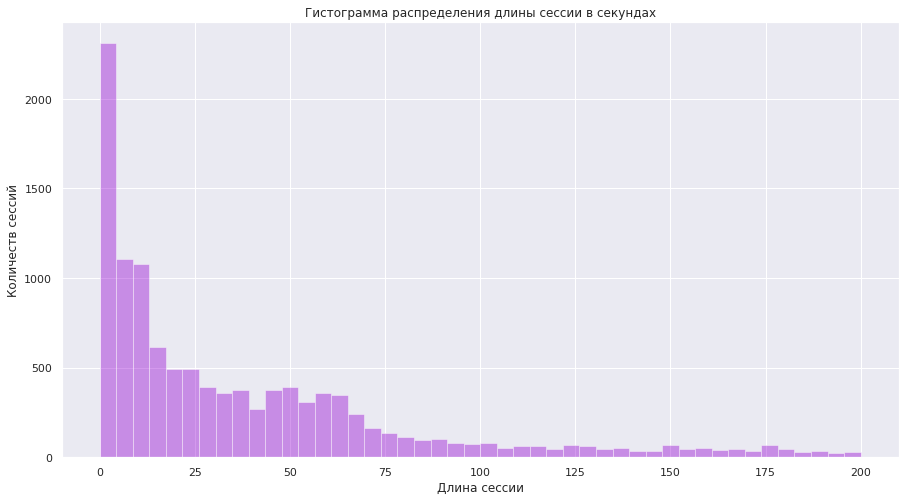

In [28]:
sns.set()
x = train_data_10users['session_timespan']
plt.figure(figsize=(15,8))
sns.distplot(x[x<=200], kde=False,  norm_hist=False, color='darkviolet')
plt.title('Гистограммa распределения длины сессии в секундах')
plt.xlabel('Длина сессии')
plt.ylabel('Количеств сессий')
plt.show()

Гистограммы распределения длины сессий


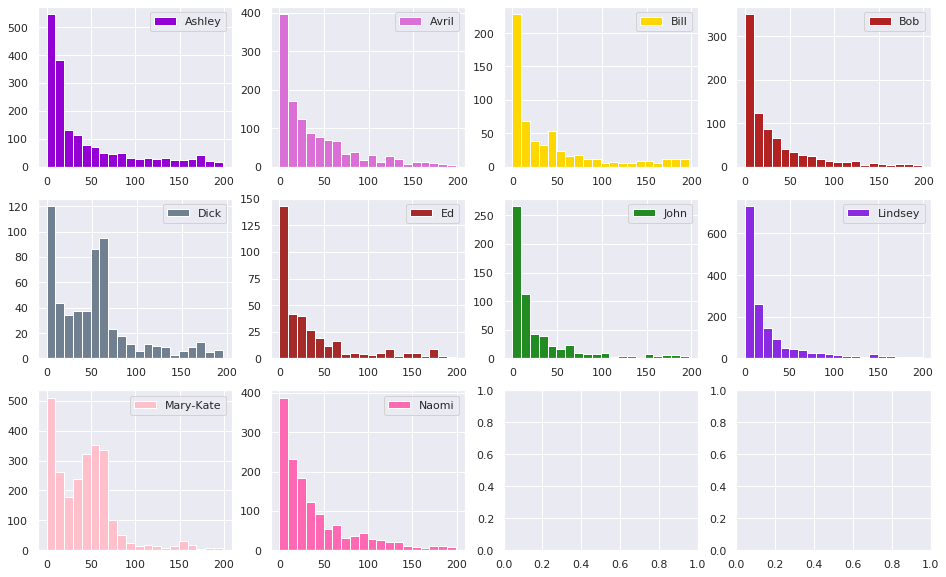

In [29]:
cols = 4
fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    x = sub_df['session_timespan']
    x[x<200].hist(bins=20, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
    axes[idx // cols, idx % cols].legend()
print("Гистограммы распределения длины сессий")

### Признак: <font color='red'><b>log session_time

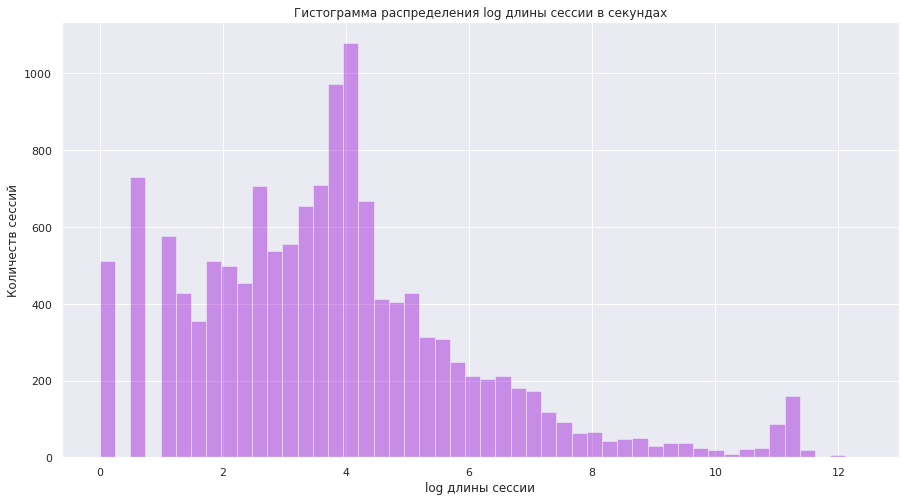

In [30]:
sns.set()
x = train_data_10users['session_timespan']
x = np.log(x[x>0])
plt.figure(figsize=(15,8))
sns.distplot(x, kde=False,  norm_hist=False, color='darkviolet')
plt.title('Гистограммa распределения log длины сессии в секундах')
plt.xlabel('log длины сессии')
plt.ylabel('Количеств сессий')
plt.show()

Гистограммы распределения длины сессий


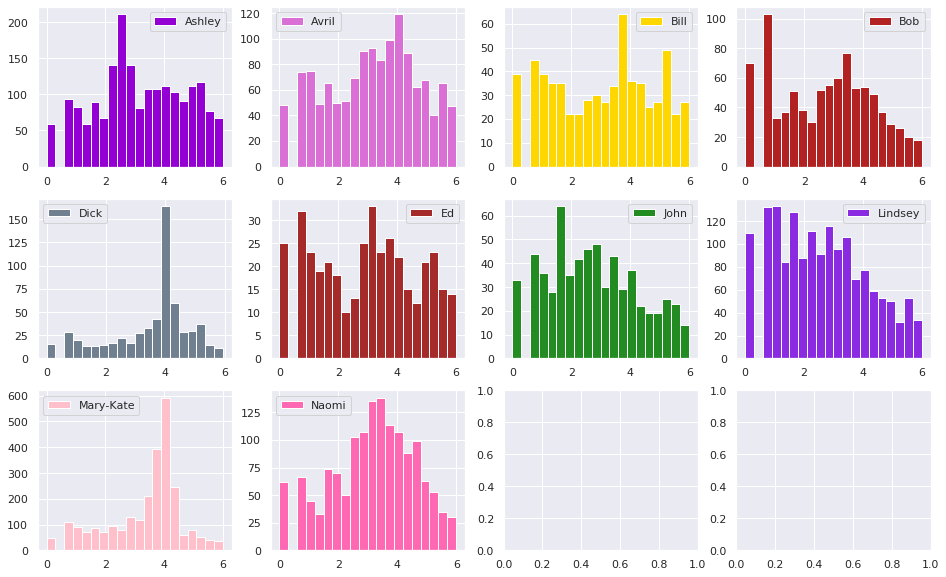

In [31]:
cols = 4
fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    x = sub_df['session_timespan']
    x = np.log(x[x>0])
    x[x<6].hist(bins=20, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
    axes[idx // cols, idx % cols].legend()
print("Гистограммы распределения длины сессий")

### <font color = "blue">#unique_sites

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

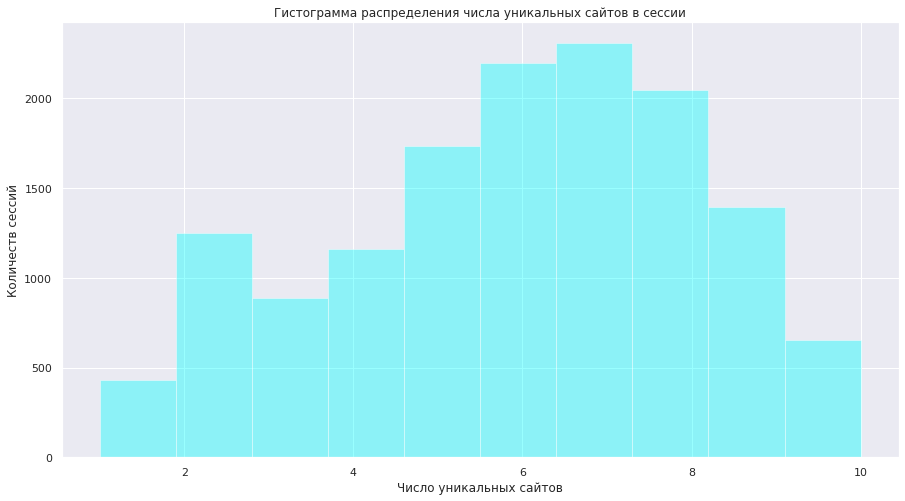

In [32]:
x = train_data_10users['#unique_sites']
plt.figure(figsize=(15,8))
sns.distplot(x, kde=False,  norm_hist=False, color='aqua', bins = 10)
plt.title('Гистограммa распределения числа уникальных сайтов в сессии')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Количеств сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

Гистограммы распределения числа уникальных сайтов в сессии


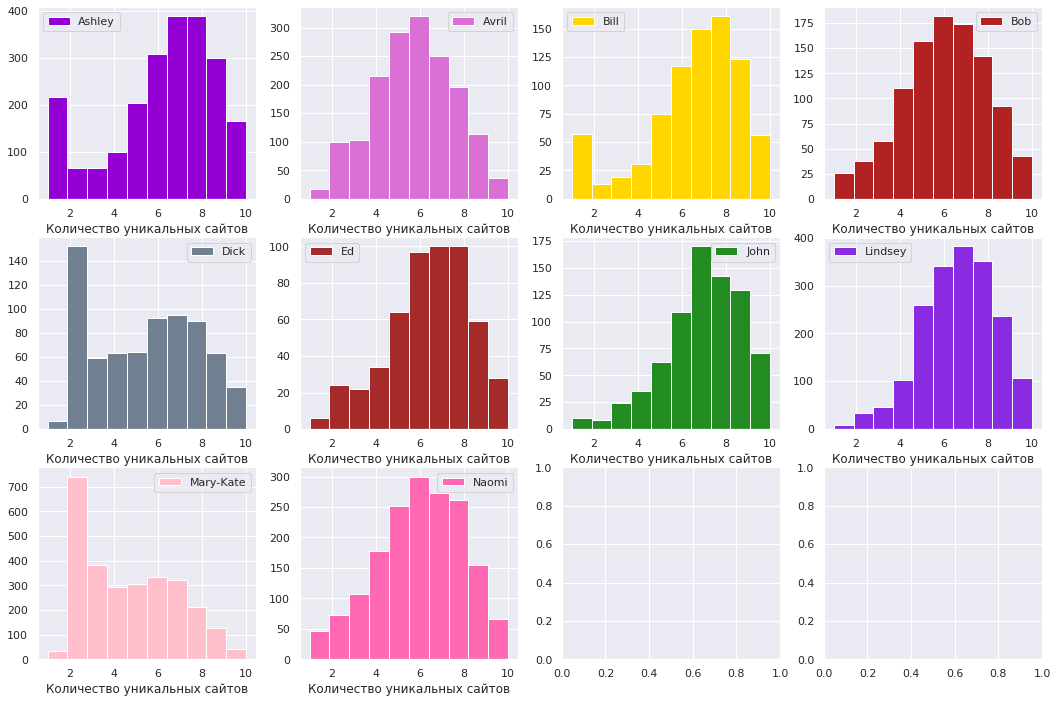

In [33]:
cols = 4
fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(18, 12))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    x = sub_df['#unique_sites']
    x.hist(bins=10, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
    axes[idx // cols, idx % cols].legend()
    axes[idx // cols, idx % cols].set_xlabel("Количество уникальных сайтов")
print("Гистограммы распределения числа уникальных сайтов в сессии")

### <font color = "blue">start_hour

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

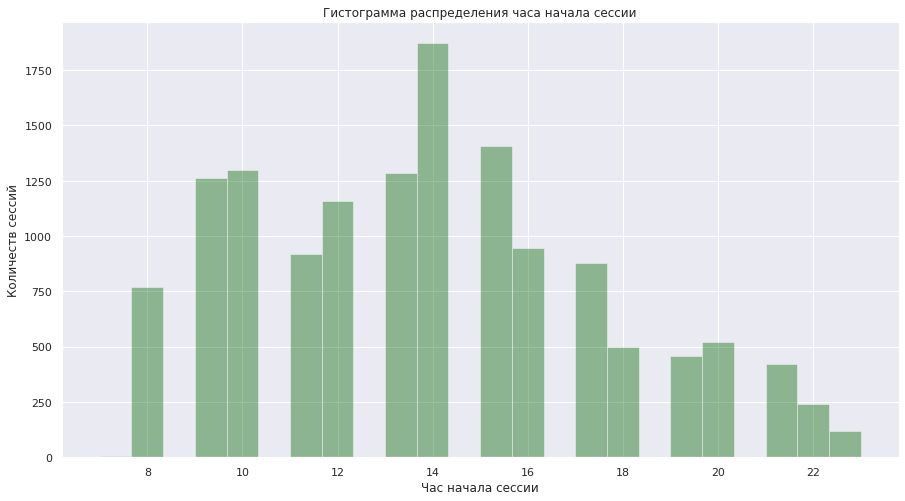

In [34]:
x = train_data_10users['start_hour']
plt.figure(figsize=(15,8))
sns.distplot(x, kde=False,  norm_hist=False, color='darkgreen', bins = 24)
plt.title('Гистограммa распределения часа начала сессии')
plt.xlabel('Час начала сессии')
plt.ylabel('Количеств сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

Гистограммы распределения часа начала сессии


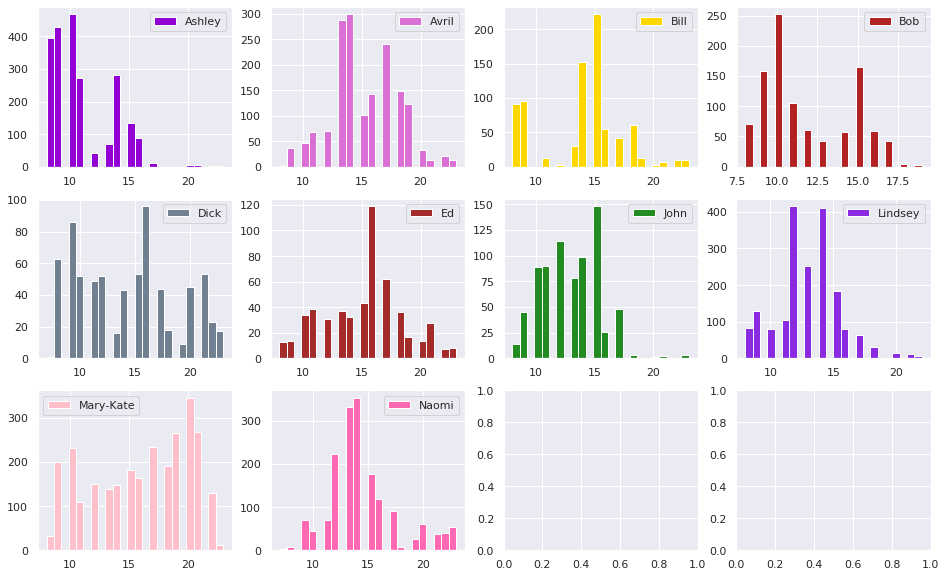

In [35]:
cols = 4
fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    x = sub_df['start_hour']
    x.hist(bins=24, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
    axes[idx // cols, idx % cols].legend()
print("Гистограммы распределения часа начала сессии")

### <font color = "blue">day_of_week

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

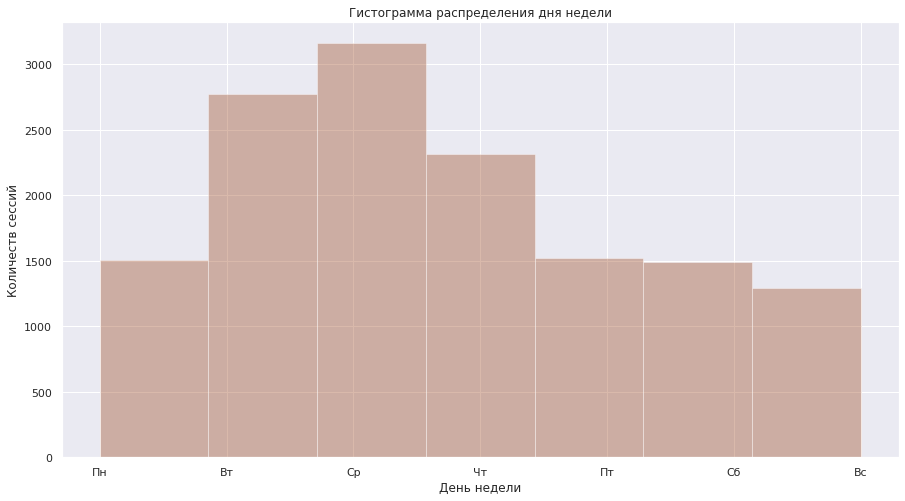

In [36]:
feature = 'day_of_week'
x = train_data_10users[feature]
plt.figure(figsize=(15,8))
ax = sns.distplot(x, kde=False,  norm_hist=False, color='sienna', bins = 7)
plt.title('Гистограммa распределения дня недели')
plt.xlabel('День недели')
plt.ylabel('Количеств сессий')
ax.set_xticks(list(range(len(x.unique()))))
ax.set_xticklabels( ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

Гистограммы распределения дня недели


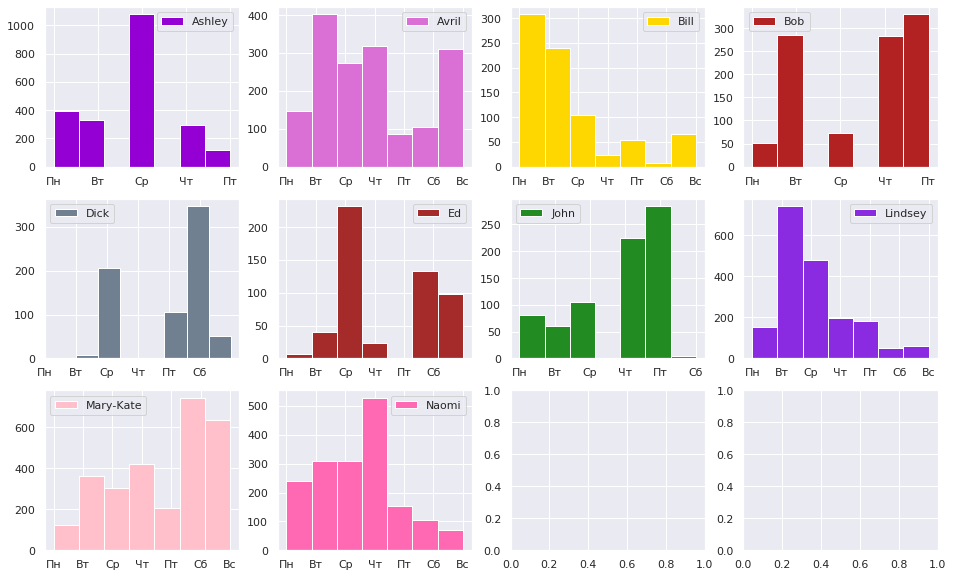

In [37]:
feature = 'day_of_week'
cols = 4
fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    x = sub_df[feature]
    x.hist(bins=7, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
    axis = axes[idx // cols, idx % cols]
    axis.legend()
    axis.set_xticks(list(range(len(x.unique()))))
    axis.set_xticklabels( ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
print("Гистограммы распределения дня недели")

###  Выводы
**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**session_timespan**

In [38]:
from statsmodels.stats.weightstats import zconfint

In [39]:
# удаление выбросов (тяжелый хвост)
x = train_data_10users[train_data_10users.session_timespan < 300]
s = x.groupby('target')['session_timespan'].mean()
s

target
Ashley       53.573348
Avril        52.270353
Bill         52.936995
Bob          38.573212
Dick         58.800664
Ed           48.947230
John         39.587859
Lindsey      35.422070
Mary-Kate    47.544112
Naomi        46.365702
Name: session_timespan, dtype: float64

In [40]:
def r(x):
    return round(x, 2)

print("Average intervals:\n")
for k in sorted(color_dic.keys()):
    s = x[x.target == k]['session_timespan']
    print('{:<10} : {:>10}'.format(k,str(tuple(map(r, zconfint(s))))))

Average intervals:

Ashley     : (50.48, 56.67)
Avril      : (48.68, 55.86)
Bill       : (47.53, 58.34)
Bob        : (34.91, 42.24)
Dick       : (54.4, 63.2)
Ed         : (42.18, 55.72)
John       : (34.84, 44.33)
Lindsey    : (32.63, 38.21)
Mary-Kate  : (45.76, 49.33)
Naomi      : (43.49, 49.24)


In [41]:
s = x.groupby('target')['session_timespan'].median()
s

target
Ashley       20.0
Avril        26.0
Bill         21.0
Bob          16.0
Dick         52.0
Ed           21.0
John         12.5
Lindsey      12.0
Mary-Kate    44.0
Naomi        25.0
Name: session_timespan, dtype: float64

In [42]:
train_data_10users.groupby('target')['#unique_sites'].median()

target
Ashley       7
Avril        6
Bill         7
Bob          6
Dick         6
Ed           7
John         7
Lindsey      7
Mary-Kate    4
Naomi        6
Name: #unique_sites, dtype: uint64

In [43]:
train_data_10users.groupby('target')['start_hour'].median()

target
Ashley       10
Avril        15
Bill         15
Bob          11
Dick         14
Ed           16
John         13
Lindsey      13
Mary-Kate    17
Naomi        14
Name: start_hour, dtype: uint64

In [44]:
s = train_data_10users.groupby('target')['day_of_week'].median()
s

target
Ashley       2
Avril        2
Bill         1
Bob          3
Dick         5
Ed           2
John         3
Lindsey      2
Mary-Kate    4
Naomi        2
Name: day_of_week, dtype: uint64

 #### **Ashley**:
    - имеет в среднем самые длиные сессии (> 50 сек) из-за редких довольно долгих сессий (тяжелый хвост  на гистограмме).
    Медианное значение сессии имеет промежуточное значение в выборке = 26 сек.
    - в сессии много уникальных сайтов.
    - рано начинает сессию
    - чаще работает по средам

#### **Avrill**:
    - имеет длинные сессии
    - в сессии среднее количество сайтов (5-6)
    - начинает сессию чаще во второй половине дня
    - реже начинает сессию по понедельникам, пятницам и субботам   

#### **Bill**: 
    - имеет длинные сессии
    - в сессии много уникальных сайтов.
    - начинает сессию чаще в середине дня
    - чаще начинает сессию по понедельникам и вторникам 

#### **Bob**:
    - имеет короткие сессии.
    - в сессии много уникальных сайтов.
    - начинает сессию чаще в начале дня и в 15-00
    - реже начинает сессию по понедельникам и средам

#### **Dick**:
    - имеет долгие сессии.
    - в сессии чаще 2 сайта.
    - начинает сессию чаще в начале дня и в 15-00
    - сессию начинает в основном либо по средам, либо на выходных

#### **Ed**
    - имеет и короткие сессии и долгие. иногда засиживается (медиана и среднее сильно разнесены).
    - в сессии много уникальных сайтов 7-8.
    - начинает сессию чаще во второй половине дня в 15-00
    - сессию начинает в основном либо по средам, либо на выходных

#### **John**
    - имеет короткие сессии.
    - в сессии много уникальных сайтов.
    - начинает сессию в первой половине дня
    - чаще начиает сессию в второй половине недели

#### **Lindsey**
    - имеет короткие сессии.
    - в сессии много уникальных сайтов 7-8.
    - начинает сессию чаще с обеда около 12-00
    - чаще начиает сессию в первой половине недели

#### **Mary-Kate**
    - имеет длинные сессии.
    - в сессии мало уникальных сайтов.
    - начинает сессию чаще в любое время, но чаще в вечернее около 20-00
    - чаще начинает сесссию по выходным

#### **Naomi**
    - имеет короткие сессии но часто засиживается (тяжелый хвост)
    - в сессии среднее количество сайтов
    - начинает сессию чаще в обед 12-00
    - большее количество сессий в четверг

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [45]:
site_freq_name = 'site_freq_10users.pkl'
with open(os.path.join(PATH_TO_DATA, site_freq_name), mode = 'rb') as site_freq:
    site_freq_10users = pickle.load(site_freq)

In [46]:
import itertools
top10 = tuple(itertools.islice(site_freq_10users.items(),10))
top10

(('s.youtube.com', (1, 8300)),
 ('www.google.fr', (2, 7813)),
 ('www.google.com', (3, 5441)),
 ('mail.google.com', (4, 4158)),
 ('www.facebook.com', (5, 4141)),
 ('apis.google.com', (6, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (7, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (8, 3094)),
 ('plus.google.com', (9, 2630)),
 ('accounts.google.com', (10, 2089)))

In [182]:
# top10
list(site_freq_10users.keys())[:10]

['s.youtube.com',
 'www.google.fr',
 'www.google.com',
 'mail.google.com',
 'www.facebook.com',
 'apis.google.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'plus.google.com',
 'accounts.google.com']

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [47]:
top10_freqs = [x[1][1]for x in top10]
top10_sites = [x[0]for x in top10]

In [48]:
top10_freqs

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]

In [49]:
top10_sites

['s.youtube.com',
 'www.google.fr',
 'www.google.com',
 'mail.google.com',
 'www.facebook.com',
 'apis.google.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'plus.google.com',
 'accounts.google.com']

Для 150users

In [183]:
site_freq_name = 'site_freq_150users.pkl'
with open(os.path.join(PATH_TO_DATA, site_freq_name), mode = 'rb') as site_freq:
    site_freq_150users = pickle.load(site_freq)

In [184]:
list(site_freq_150users.keys())[:50]

['www.google.fr',
 'www.google.com',
 'www.facebook.com',
 'apis.google.com',
 's.youtube.com',
 'clients1.google.com',
 'mail.google.com',
 'plus.google.com',
 'safebrowsing-cache.google.com',
 'www.youtube.com',
 'twitter.com',
 'platform.twitter.com',
 's-static.ak.facebook.com',
 'accounts.google.com',
 'www.bing.com',
 'i1.ytimg.com',
 'static.ak.facebook.com',
 'download.jboss.org',
 'api.twitter.com',
 'safebrowsing.clients.google.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'fr.openclassrooms.com',
 'ajax.googleapis.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'drive.google.com',
 'r2---sn-gxo5uxg-jqbe.googlevideo.com',
 'r4---sn-gxo5uxg-jqbe.googlevideo.com',
 's.ytimg.com',
 'login.live.com',
 'fr-mg42.mail.yahoo.com',
 'ocsp.digicert.com',
 'bits.wikimedia.org',
 'connect.facebook.net',
 'docs.google.com',
 'clients1.google.fr',
 'translate.google.fr',
 'ts1.mm.bing.net',
 'maps.googleapis.com',
 'mangafox.me',
 'fr.wikipedia.org',
 'apr.lijit.com',
 'clients2.google.c

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

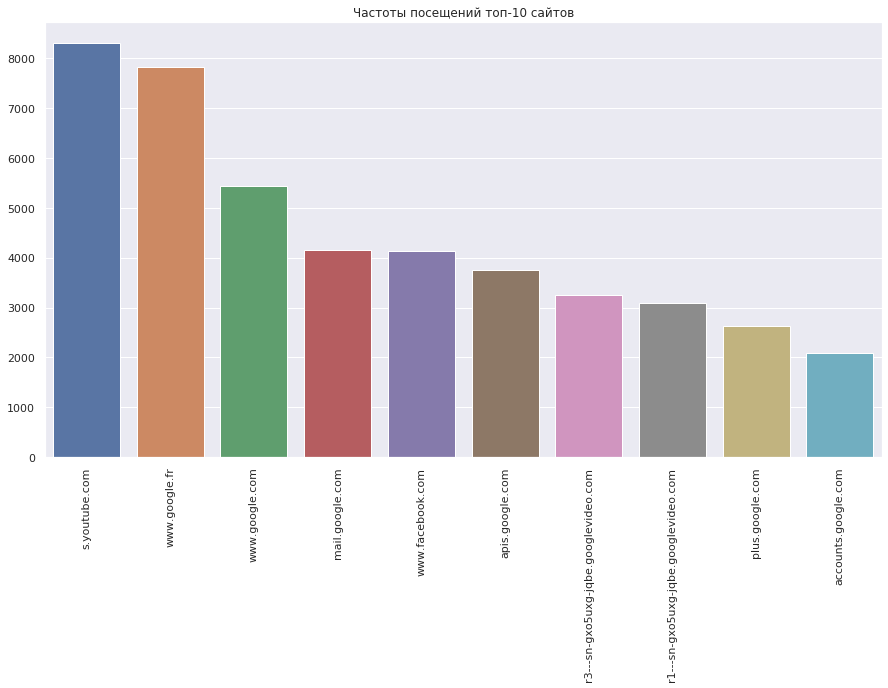

In [50]:
plt.figure(figsize=(15,8))
sns.barplot(x = top10_sites, y = top10_freqs)
plt.xticks(range(len(top10_sites)), top10_sites, rotation = 90)
plt.title('Частоты посещений топ-10 сайтов')
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

<font color= 'green'>    Новые Признаки:
    - год, месяц и день начала сессии
    - рабочие часы (9-18)
    - время суток (am/pm)
    - количество популярных сайтов в сессии
    - индикатор посещения популярных сайтов (топ30)
    - среднее время пребывания на популярных сайтах

In [185]:
entertainment = ['youtube', 'vk', 'facebook', 'twitter', 'linkedin', 'wikipedia', 'googlevideo', 'melty', 'wikimedia', 'mangafox']

search = ['yandex.com', 'google.com', 'yahoo.com', 'bing']
     
work = ['oracle', 'microsoft', 'jboss', 'googleapis', 'live.com']

In [136]:
def get_topsites (site_dict, number):
    return list(site_dict.keys())[:number]

In [52]:
def is_business_hours(time):
    hs = time.dt.hour
    return [1 if(h >= 8 and h <= 18) else 0 for h in hs]

In [53]:
def is_pm(time):
    hs = time.dt.hour
    return [1 if(h >= 12 and h <= 24) else 0 for h in hs]

In [151]:
def mode_count(sites, mode):
    return np.sum(ismode(sites, mode), axis=1)

In [161]:
def ismode(sites, mode):
    return [[True in [m in s for m in mode] for s in row] for row in sites]

In [143]:
def time_inmode(times, sites, mode):
    modes = ismode(sites, mode)
    return np.sum([[t if m is True else 0 for t, m in zip(trow, mrow)] for trow, mrow in zip(times, modes)], axis=1)

In [174]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                        session_length=10, window_size=10):
    """
    The function returns DataFrame of sessions with new features.
    """
    # Create table with features : time_diff, session_timespan, session_timespan, day_of_week, start_hour
    table = prepare_train_set_with_fe(
        path_to_csv_files, site_freq_path, feature_names, session_length, window_size)
    table_array = np.array(table)

#     ----- Load site_freq
    with open(site_freq_path, 'rb') as site_pkl:
        sites_freq = pickle.load(site_pkl)
    
    top30 = get_topsites(sites_freq,30)

    sitesbyid = dict([(v[0], k) for k, v in sites_freq.items()])

#     ----- Determine parameters for a table shape
#     Load .csv files
    files = glob(path_to_csv_files+"/*")
    sessions_numbers, targets = get_parameters(files, window_size)
#     ----- Columns index in feature_names
    feature_index = dict(zip(feature_names, range(len(feature_names))))

    line = 0
    for f, sn in zip(files, sessions_numbers):
        data = pd.read_csv(f)
        ts = pd.to_datetime(data['timestamp'])
        sites = [[sitesbyid.get(e, ' ') for e in row]
                 for row in table_array[line:line+sn, :session_length]]
        time_diffs = table_array[line:line+sn,
                                 session_length:2*session_length-1]

#       'start_year'
        table_array[line:line+sn,
                    feature_index['start_year']] = ts[::window_size].dt.year
#       'start_month'
        table_array[line:line+sn,
                    feature_index['start_month']] = ts[::window_size].dt.month
#       'start_hour'
        table_array[line:line+sn,
                    feature_index['start_hour']] = ts[::window_size].dt.hour
#       'start_in_business_hours'
        table_array[line:line+sn,
                    feature_index['start_in_business_hours']] = is_business_hours(ts[::window_size])
#       'start_in_pm'
        table_array[line:line+sn,
                    feature_index['start_in_pm']] = is_pm(ts[::window_size])
    
    

#       'entertainment count'
        table_array[line:line+sn,
                    feature_index['entertainment_count']] = mode_count(sites, entertainment)
#       'entertainment time'    
        table_array[line:line+sn,
                    feature_index['entertainment_time']] = time_inmode(time_diffs, sites, entertainment)

#       'search count'
        table_array[line:line+sn,
                    feature_index['search_count']] = mode_count(sites, search)
#       'search time'    
        table_array[line:line+sn,
                    feature_index['search_time']] = time_inmode(time_diffs, sites, search)

#       'work count'
        table_array[line:line+sn,
                    feature_index['work_count']] = mode_count(sites, work)
#       'work time'    
        table_array[line:line+sn,
                    feature_index['work_time']] = time_inmode(time_diffs, sites, work)
#       'top30'
        table_array[line:line+sn,
                    feature_index['top30_count']] = mode_count(sites, top30)
#       'top30 time'    
        table_array[line:line+sn,
                    feature_index['top30_time']] = time_inmode(time_diffs, sites, top30)

        line += sn

    return pd.DataFrame(data=table_array, columns=feature_names)

Check on toy matrix

In [175]:
feature_names = ['site' + str(i) for i in range(1, 11)] + \
                ['time_diff' + str(j) for j in range(1, 10)] + \
                ['session_timespan', '#unique_sites', 'day_of_week',
                 'start_year', 'start_month', 'start_day', 'start_hour',
                 'start_in_business_hours', 'start_in_pm',  'sum_of_popular', 'is_popular', 'popular_time',
                 'entertainment_count', 'entertainment_time',
                 'search_count', 'search_time',
                 'work_count', 'work_time',
                 'top30_count','top30_time',
                 'target']

table = feature_engineering(os.path.join(PATH_TO_DATA, '3users'),
                            site_freq_path=os.path.join(
    PATH_TO_DATA, 'site_freq_3users.pkl'),
    feature_names=feature_names, session_length=10)


table[['site' + str(i) for i in range(1, 11)]+['time_diff' + str(j) for j in range(1, 10)]+['session_timespan']]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60
2,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998
3,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471
4,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935


In [164]:
table[['entertainment_count', 'entertainment_time',
                 'search_count', 'search_time',
                 'work_count', 'work_time',
                 'top30_count','top30_time']]

,entertainment_count,entertainment_time,search_count,search_time,work_count,work_time,top30_count,top30_time
0,1,287,5,61,3,7464,10,7998
1,1,2,3,58,0,0,4,60
2,0,0,5,1376,2,6280,10,7998
3,0,0,1,1184,1,0,3,1471
4,1,287,0,0,2,1184,5,7935


Apply on 10users table

In [176]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                    site_freq_path=os.path.join(
                        PATH_TO_DATA, 'site_freq_10users.pkl'),
                    feature_names=feature_names, session_length=10)

CPU times: user 3.3 s, sys: 15.7 ms, total: 3.31 s
Wall time: 3.31 s


In [177]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,sum_of_popular,is_popular,popular_time,entertainment_count,entertainment_time,search_count,search_time,work_count,work_time,top30_count,top30_time,target
0,60,60,265,39,39,69,160,69,67,67,2,2,...,0,0,0,0,0,0,0,5,844,0,0,100
1,72,15,207,574,534,23,37,23,80,85,0,4,...,0,0,0,0,0,5,185,0,0,3,61,100
2,52,37,23,37,23,23,39,39,69,69,1451,0,...,0,0,0,0,0,5,4473,4,162,3,4473,100
3,160,69,69,160,39,69,160,39,39,81,17281,1,...,0,0,0,0,0,0,0,10,95450,0,0,100
4,164,310,164,167,182,161,161,167,61,81,0,1,...,0,0,0,0,0,0,0,9,6,0,0,100


In [167]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                    site_freq_path=os.path.join(
                        PATH_TO_DATA, 'site_freq_10users.pkl'),
                    feature_names=feature_names, session_length=10)

CPU times: user 3.25 s, sys: 11.6 ms, total: 3.27 s
Wall time: 3.26 s


In [178]:
new_features_10users[new_features_10users.entertainment_count>0].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,sum_of_popular,is_popular,popular_time,entertainment_count,entertainment_time,search_count,search_time,work_count,work_time,top30_count,top30_time,target
7,21,27,897,30,6,3,10,33,9,80,1,0,...,0,0,0,1,1,6,128,0,0,8,129,100
10,69,69,160,15,72,3,2,15,15,561,1,0,...,0,0,0,1,0,4,23,3,14,5,24,100
11,561,207,3,2,2,37,23,23,561,561,7,7,...,0,0,0,3,38,4,4,0,0,5,58,100
13,23,37,23,9,9,39,39,39,67,2086,0,1,...,0,0,0,1,0,5,59890,3,16610,4,59889,100
14,13,38,38,72,15,38,19,13,1,38,0,1,...,0,0,0,3,0,1,1,0,0,5,2,100


Apply on 150user table

In [186]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                    site_freq_path=os.path.join(
                        PATH_TO_DATA, 'site_freq_150users.pkl'),
                    feature_names=feature_names, session_length=10)

CPU times: user 32.4 s, sys: 114 ms, total: 32.5 s
Wall time: 32.5 s


In [190]:
new_features_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,sum_of_popular,is_popular,popular_time,entertainment_count,entertainment_time,search_count,search_time,work_count,work_time,top30_count,top30_time,target
0,1,4,2,1,4,2,25,14,46,1,1,2,...,0,0,0,1,25,6,122,0,0,10,148,106
1,25,51,51,46,1,2,14,51,4,25,7,2,...,0,0,0,1,0,5,8,0,0,7,8,106
2,868,902,858,751,902,751,25,85,751,25,0,0,...,0,0,0,0,0,10,2,0,0,3,1,106
3,902,868,858,751,868,751,858,25,8,2,0,0,...,0,0,0,0,0,10,6,0,0,3,0,106
4,751,34,34,1,4,2,8,34,42,34,0,1,...,0,0,0,0,0,9,13,0,0,4,9,106


In [189]:
new_features_150users[new_features_150users.top30_count==10].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,sum_of_popular,is_popular,popular_time,entertainment_count,entertainment_time,search_count,search_time,work_count,work_time,top30_count,top30_time,target
0,1,4,2,1,4,2,25,14,46,1,1,2,...,0,0,0,1,25,6,122,0,0,10,148,106
987,1,4,14,4,1,2,2,8,8,2,0,3,...,0,0,0,0,0,8,41,0,0,10,42,106
1030,1,4,1,8,1,8,13,11,3,11,43,119,...,0,0,0,4,32,3,173,0,0,10,251,106
1031,1,8,1,8,1,1,4,8,4,1,146,0,...,0,0,0,0,0,5,46,0,0,10,938,106
1032,1,1,1,8,1,8,1,4,1,2,1749,6,...,0,0,0,0,0,4,73699,0,0,10,75470,106


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

## Анализ новых признаков

Анализ новых признаков на примере 10users таблице.

In [62]:
# Идентификация пользователя по имени
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [63]:
# Список новых признаков
new_features = ['start_year', 'start_month', 'start_day', 'start_hour',
                 'start_in_business_hours', 'last_in_business_hours',
                 'start_in_pm', 'last_in_pm', 'sum_of_popular', 'is_popular', 'popular_time',
                 'target']

In [64]:
new_features_10users[new_features].head()

,start_year,start_month,start_day,start_hour,start_in_business_hours,last_in_business_hours,start_in_pm,last_in_pm,sum_of_popular,is_popular,popular_time,target
0,2013,11,15,12,1,1,1,1,0,0,0,Dick
1,2013,11,15,12,1,1,1,1,3,1,20,Dick
2,2013,11,15,12,1,1,1,1,3,1,1491,Dick
3,2013,11,15,14,1,1,1,1,0,0,0,Dick
4,2013,11,17,16,1,1,1,1,0,0,0,Dick


In [65]:
def plot_hist(x, color, title, xlabel, ylabel, rotation = 0):
    plt.figure(figsize=(15,8))
    sns.distplot(x, kde=False,  norm_hist=False, color=color)
    plt.title(title)
    plt.xticks(x.unique(), rotation = rotation)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [66]:
def plot_hist_by_users(data, x_name, title, rotation = 0):
    cols = 4
    fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(20, 10))
    for idx, (user, sub_df) in enumerate(data.groupby('target')):
        x = sub_df[x_name]
        a = x.hist(bins=10, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
        a.set_xticks(x.unique())
        a.xaxis.set_tick_params(rotation=rotation)
        axes[idx // cols, idx % cols].legend()
    print(title)

#### Признак: <font color = "red"><b>start_year

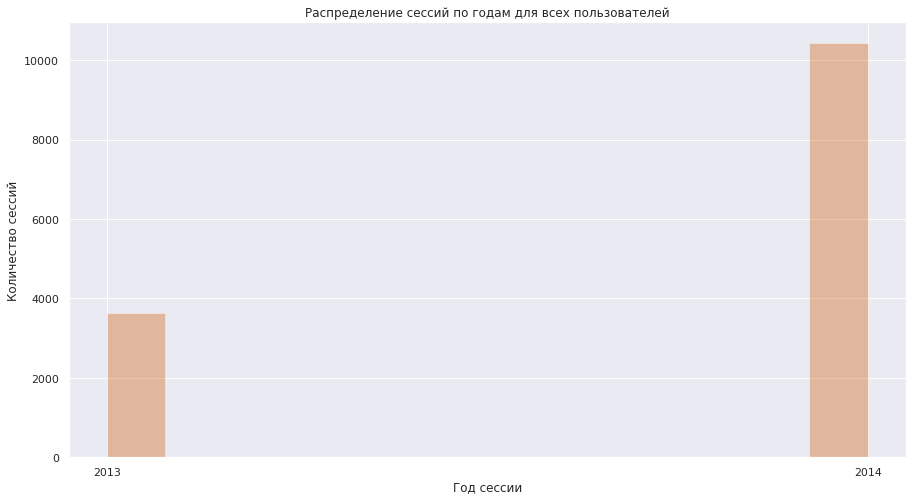

In [67]:
x = new_features_10users['start_year']
plot_hist(
    x=x,
    color="chocolate",
    title="Распределение сессий по годам для всех пользователей",
    xlabel="Год сессии",
    ylabel="Количество сессий")

Гистограммы распределений по годам


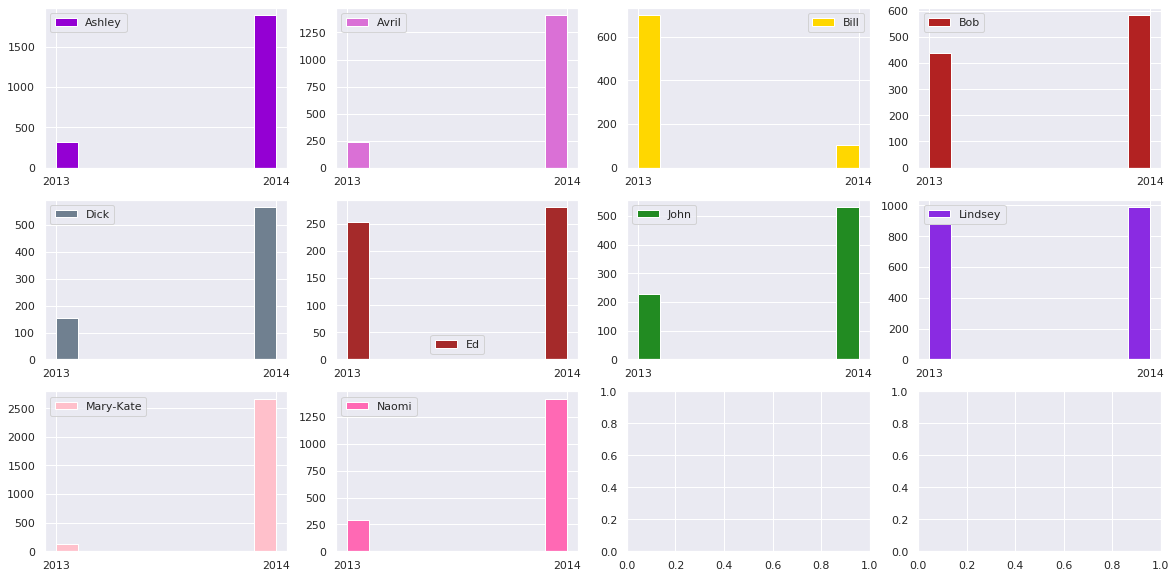

In [68]:
plot_hist_by_users(new_features_10users, 'start_year', "Гистограммы распределений по годам")

#### Признак: <font color = "red"><b>start_month

In [1]:
x = new_features_10users['start_month']
plot_hist(x,
          color="goldenrod",
          title="Гистограмма распределения месяца старта сессии",
          xlabel="Месяц старта сессии",
          ylabel="Количество сессии",
          bins=12)

NameError: name 'new_features_10users' is not defined

Гистограммы распределений по месяцам


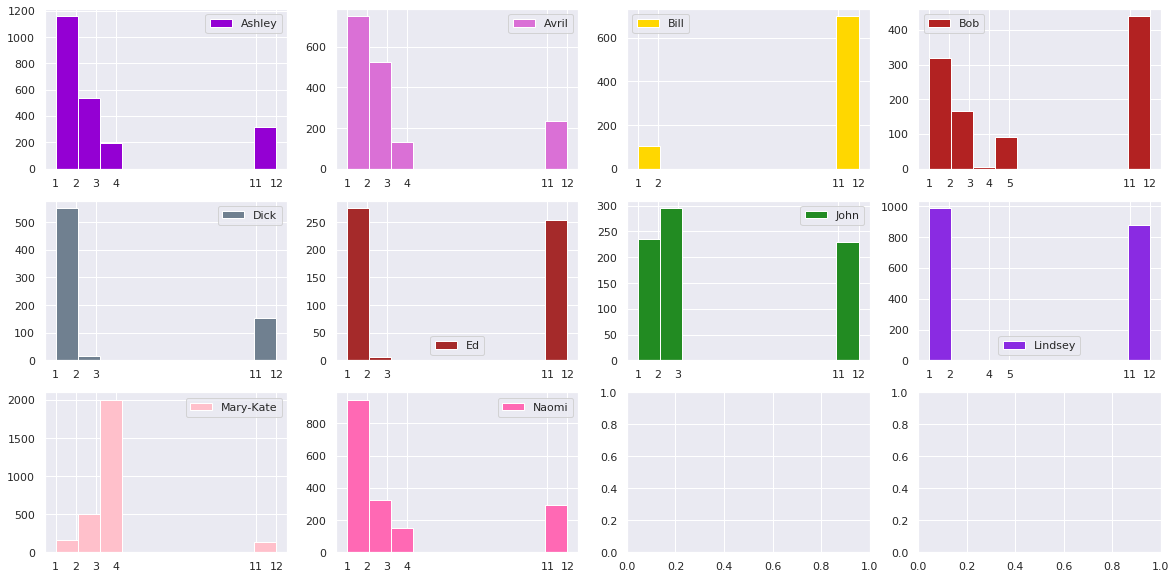

In [70]:
plot_hist_by_users(new_features_10users, 'start_month', "Гистограммы распределений по месяцам")

#### Признак: <font color = "red"><b>start_day

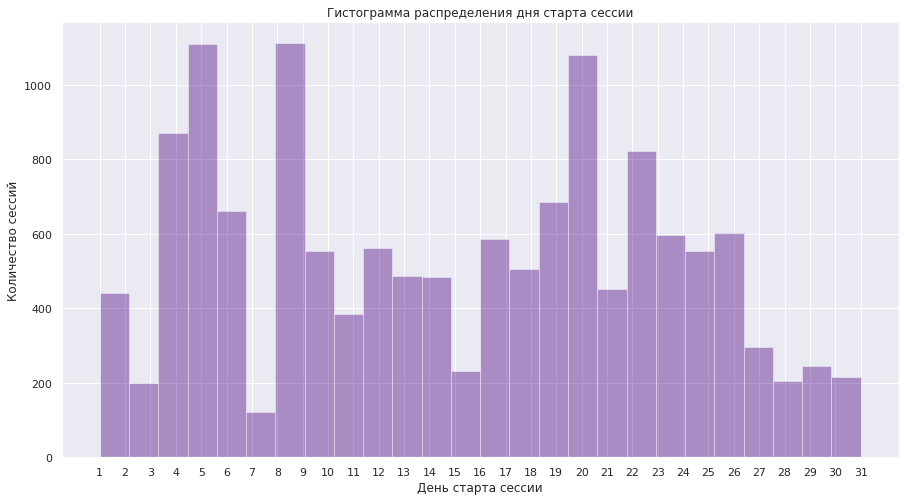

In [71]:
x = new_features_10users['start_day']
plot_hist(x,
          color="indigo",
          title="Гистограмма распределения дня старта сессии",
          xlabel="День старта сессии",
          ylabel="Количество сессий",
          bins=31)

Гистограммы распределений по дням


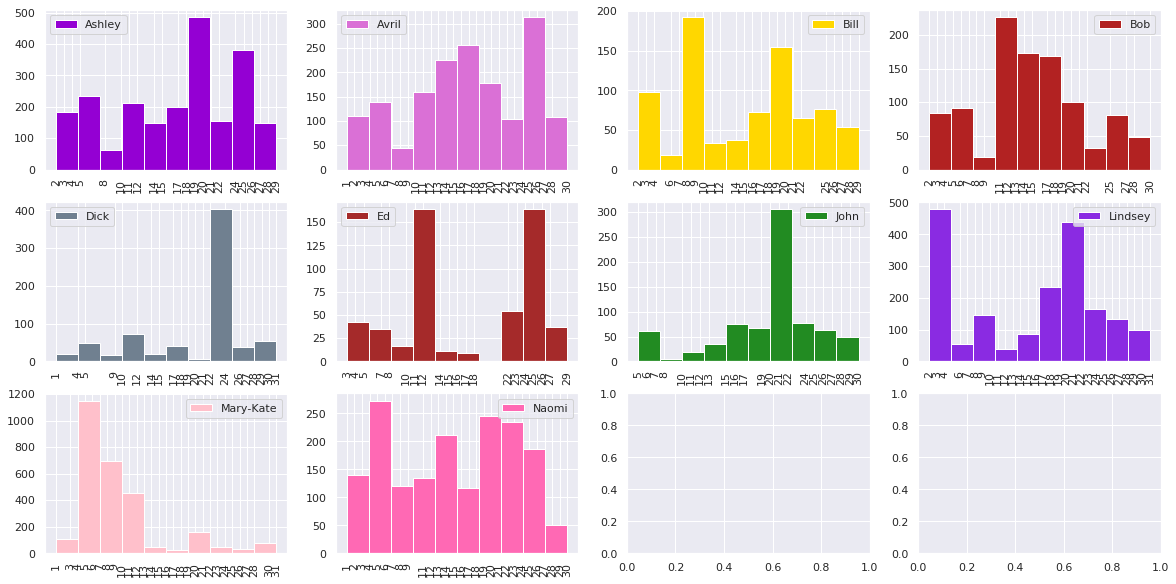

In [72]:
plot_hist_by_users(new_features_10users, 'start_day', "Гистограммы распределений по дням", rotation = 90)

#### Признак: <font color = "red"><b>start_in_business_hours

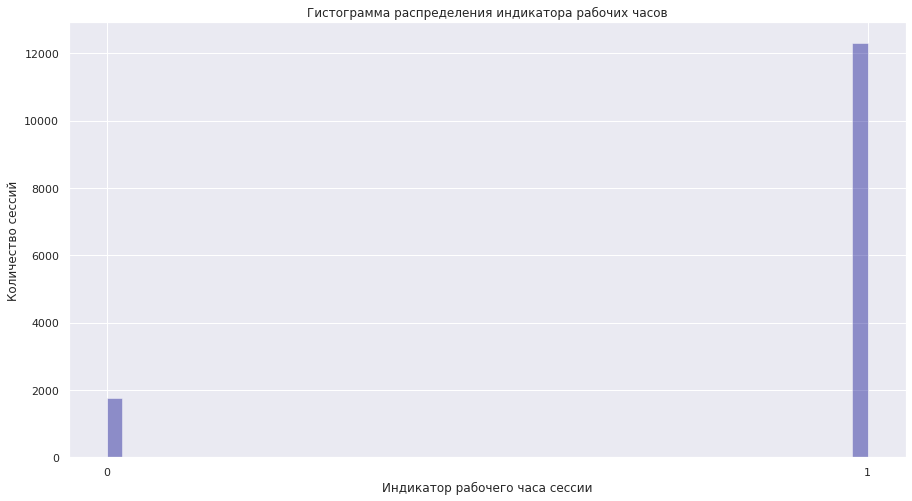

In [73]:
x = new_features_10users['start_in_business_hours']
plot_hist(x, 
          color = "darkblue", 
          title = "Гистограмма распределения индикатора рабочих часов", 
          xlabel = "Индикатор рабочего часа сессии", 
          ylabel = "Количество сессий")

Гистограммы распределений по индикаторам рабочих часов


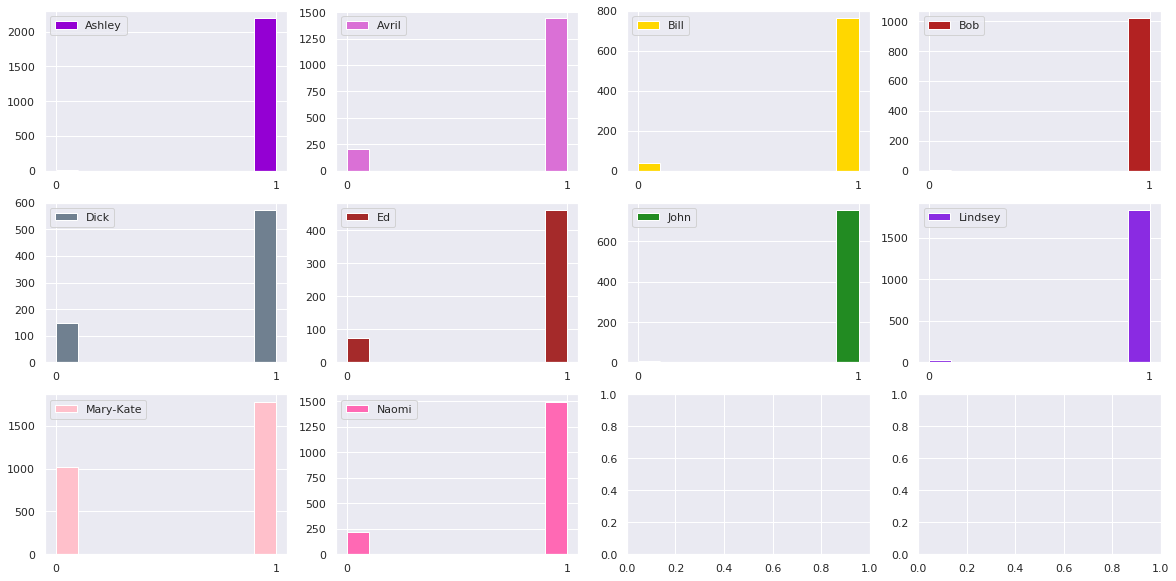

In [74]:
plot_hist_by_users(new_features_10users, 
                   'start_in_business_hours', 
                   "Гистограммы распределений по индикаторам рабочих часов")

#### Признак: <font color = "red"><b>start_in_pm

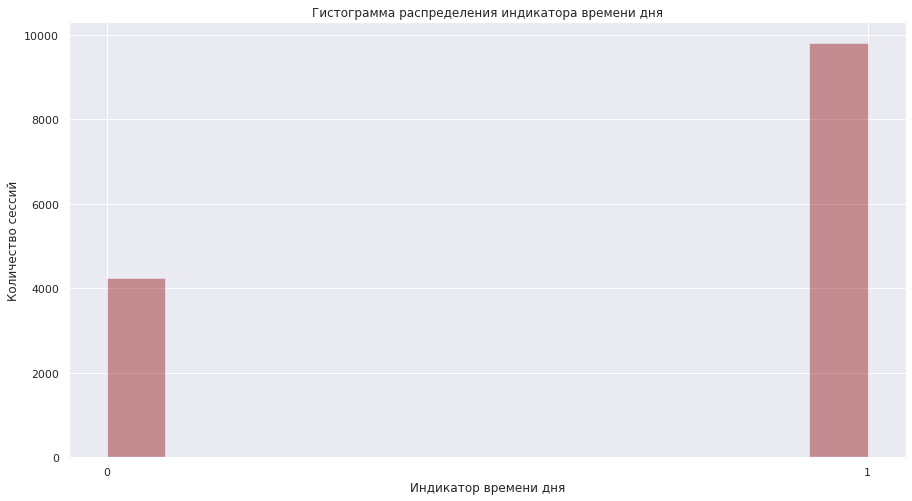

In [75]:
x = new_features_10users['start_in_pm']
plot_hist(x, 
          color = "darkred", 
          title = "Гистограмма распределения индикатора времени дня", 
          xlabel = "Индикатор времени дня", 
          ylabel = "Количество сессий")

Гистограммы распределений по индикаторам времени дня


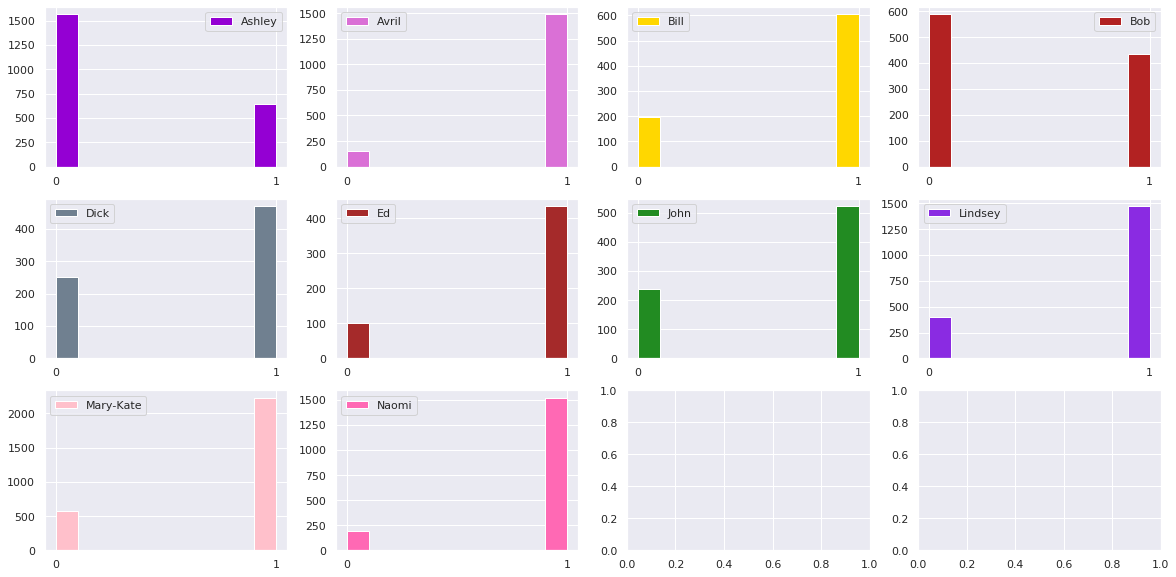

In [76]:
plot_hist_by_users(new_features_10users, 
                   'start_in_pm', 
                   "Гистограммы распределений по индикаторам времени дня")

#### Признак: <font color = "red"><b>popular_time

In [77]:
def plot_hist_continuous(x, color, title, xlabel, ylabel, rotation = 0):
    plt.figure(figsize=(15,8))
    sns.distplot(np.log(x), kde=False,  norm_hist=False, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [78]:
def plot_hist_by_users_continuous(data, x_name, title, rotation = 0):
    cols = 4
    fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(20, 10))
    for idx, (user, sub_df) in enumerate(data.groupby('target')):
        x = np.log(sub_df[x_name])
        a = x.hist(bins=10, label = user, ax=axes[idx // cols, idx % cols], color = color_dic[user])
        a.xaxis.set_tick_params(rotation=rotation)
        axes[idx // cols, idx % cols].legend()
    print(title)

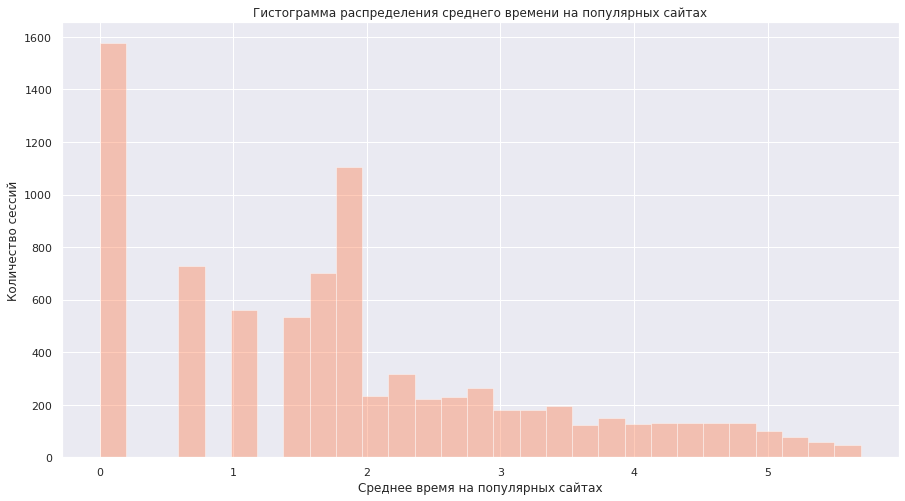

In [79]:
x = new_features_10users['popular_time']
plot_hist_continuous(x[x<5*60][x>0], # less 5 minutes
          color = "coral", 
          title = "Гистограмма распределения среднего времени на популярных сайтах", 
          xlabel = "Среднее время на популярных сайтах", 
          ylabel = "Количество сессий")

Гистограммы распределений по индикаторам рабочих часов


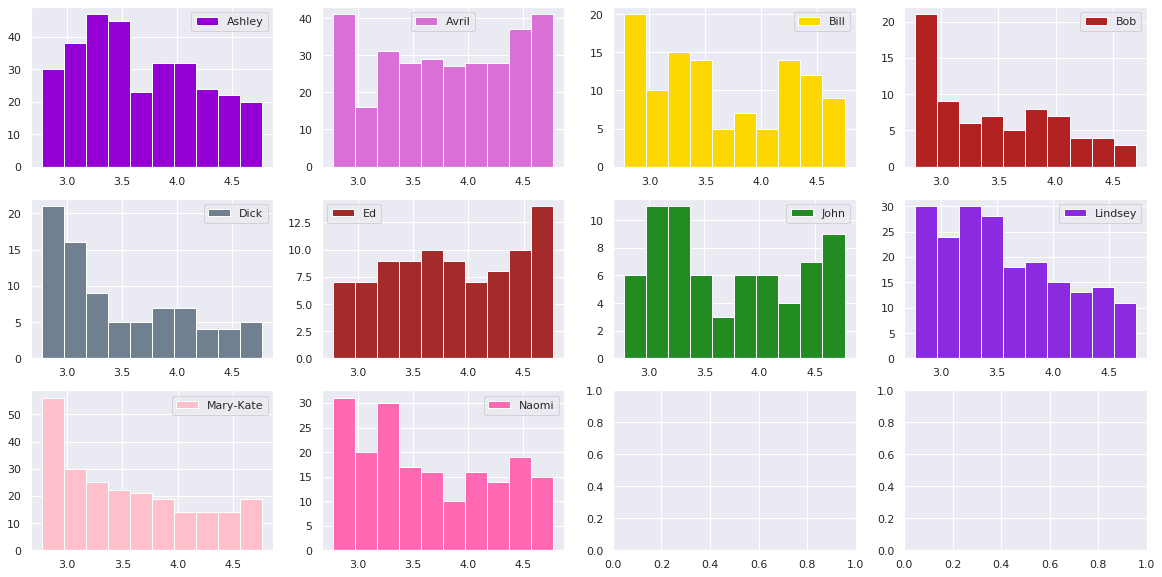

In [80]:
x = new_features_10users[new_features_10users['popular_time']<2*60][new_features_10users['popular_time']>15]
plot_hist_by_users_continuous(x, 
                   'popular_time', 
                   "Гистограммы распределений по индикаторам рабочих часов")

#### Признак: <font color = "red"><b>entertainment_time

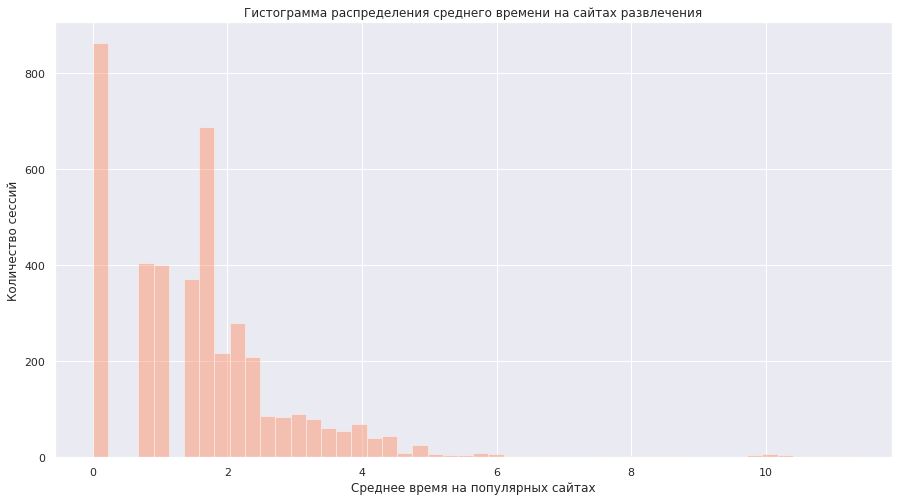

In [81]:
x = new_features_10users['entertainment_time']
plot_hist_continuous(x[x>0], # less 5 minutes
          color = "coral", 
          title = "Гистограмма распределения среднего времени на сайтах развлечения", 
          xlabel = "Среднее время на популярных сайтах", 
          ylabel = "Количество сессий")

Гистограммы распределений по entertainment часам


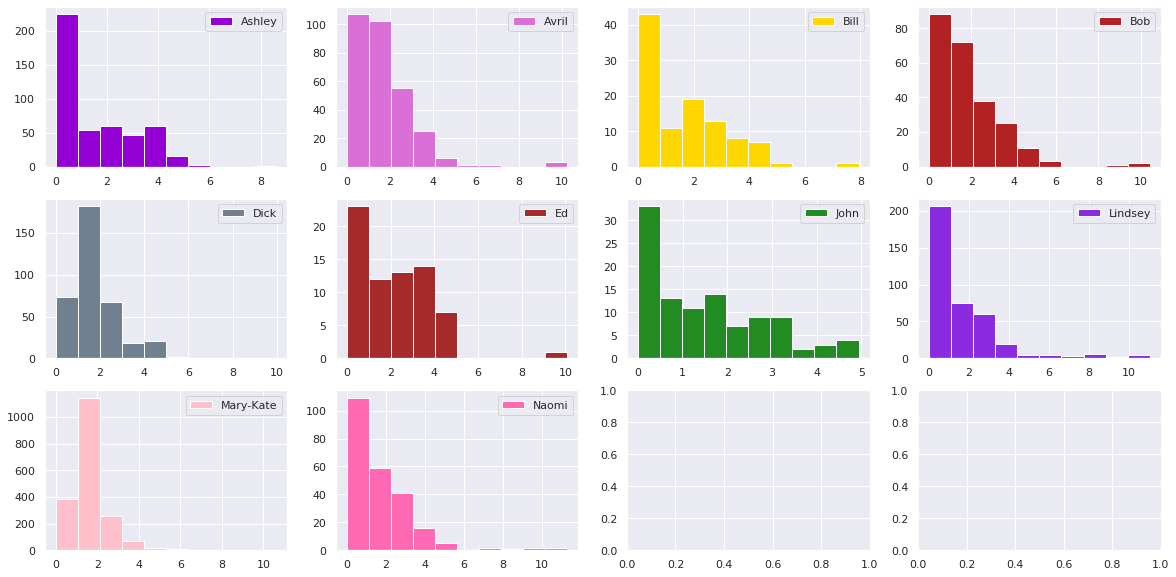

In [82]:
x = new_features_10users
x = x[x['entertainment_time']>0]
plot_hist_by_users_continuous(x, 
                   'entertainment_time', 
                   "Гистограммы распределений по entertainment часам")

#### Признак: <font color = "red"><b>search_time

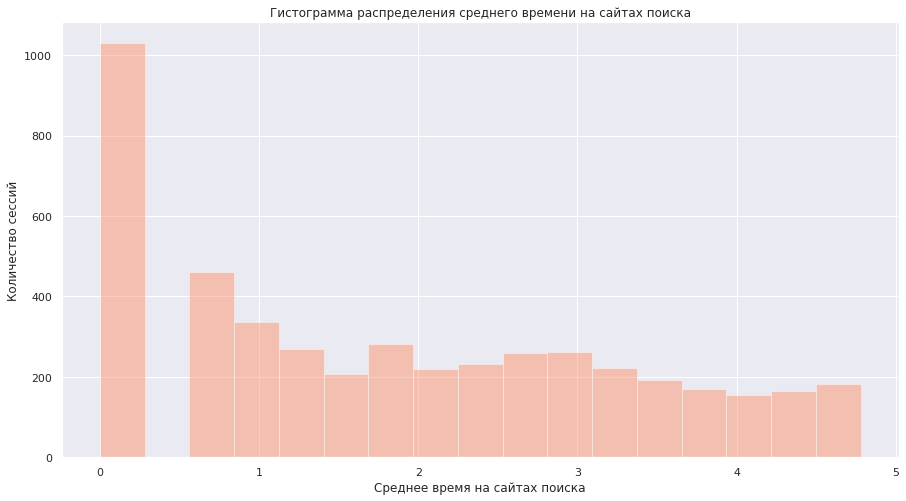

In [83]:
x = new_features_10users['search_time']
plot_hist_continuous(x[x<2*60][x>0], # less 5 minutes
          color = "coral", 
          title = "Гистограмма распределения среднего времени на сайтах поиска", 
          xlabel = "Среднее время на сайтах поиска", 
          ylabel = "Количество сессий")

Гистограммы распределений по search часам


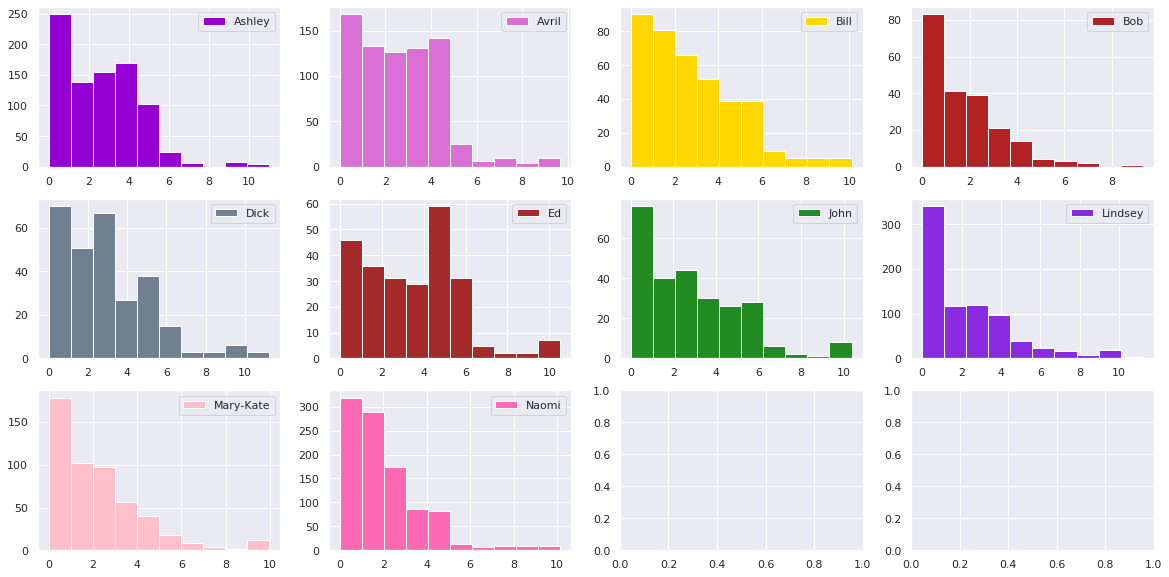

In [84]:
name = 'search_time'
x = new_features_10users[new_features_10users[name]>0]
plot_hist_by_users_continuous(x, 
                   name, 
                   "Гистограммы распределений по search часам")

#### Признак: <font color = "red"><b>work_time

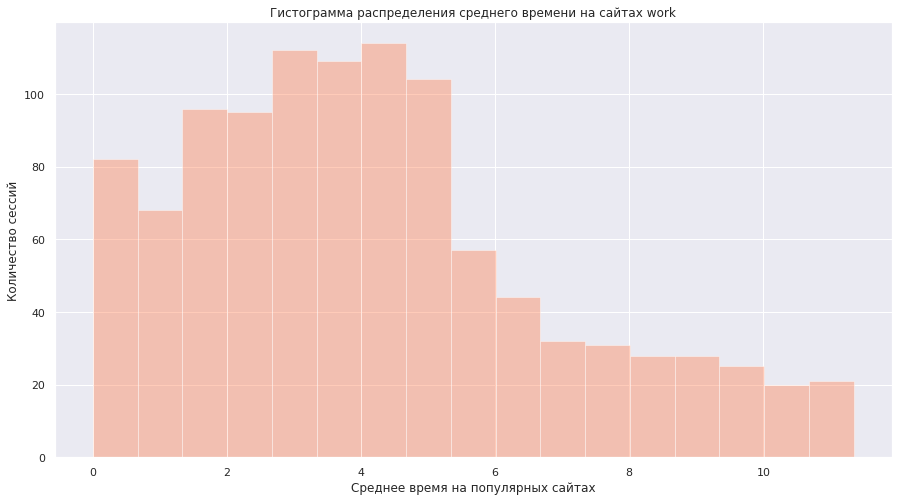

In [85]:
x = new_features_10users['work_time']
plot_hist_continuous(x[x>0], # less 5 minutes
          color = "coral", 
          title = "Гистограмма распределения среднего времени на сайтах work", 
          xlabel = "Среднее время на популярных сайтах", 
          ylabel = "Количество сессий")

Гистограммы распределений по work часам


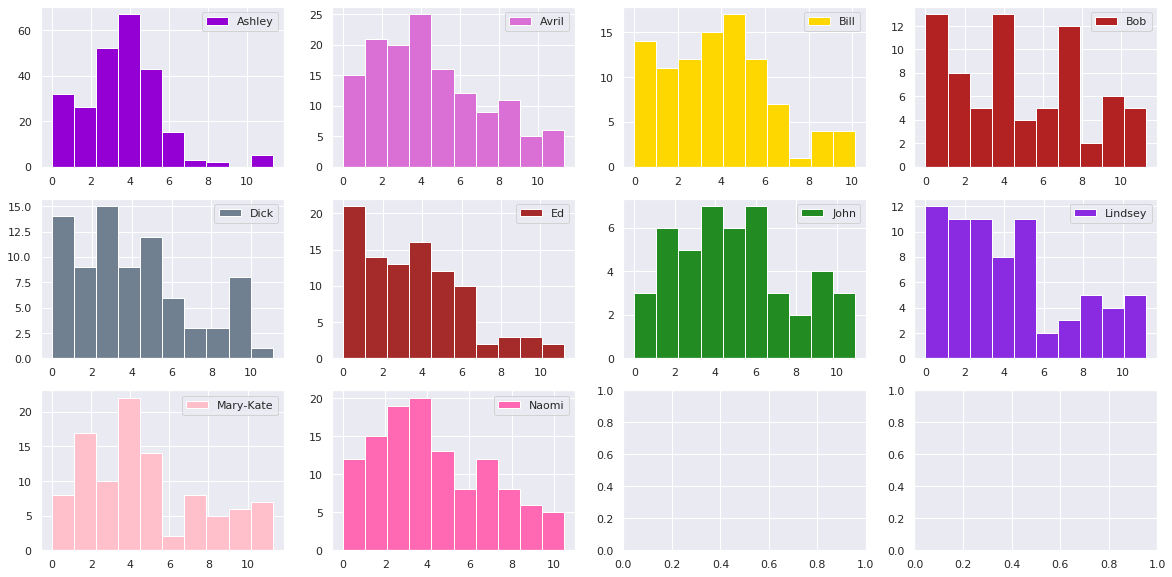

In [86]:
name = 'work_time'
x = new_features_10users[new_features_10users[name]>0]
plot_hist_by_users_continuous(x, 
                   name, 
                   "Гистограммы распределений по work часам")

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

 <font color = 'red'><b>start_year</b></font> не годится, так как он не важен в далнейшей идентификации.
 
 <font color = 'red'><b>start_month</b></font> не годится по этой же причине
 
 <font color = 'green'><b>start_day</b></font> пригодится так как определяет режим работы человека в недельном цикле
 
 <font color = 'green'><b>start_in_pm</b></font> показал лучше чем  <font color = 'red'><b>start_in_business_hours</b></font>
 
 среди вычислений средней длины сессии из примеров выше показала лучшие результаты группа search=['yandex.com', 'google.com', 'yahoo.com'], но стоит поискать лучшие сайты, на которых классы лучше разбиваются (поодиночке или группой)

In [87]:
features_to_save = ['session_timespan', '#unique_sites', 'start_hour',
                    'day_of_week', 'start_day', 'start_in_pm', 'entertainment_time', 'search_time', 'work_time']

selected_features_10users = new_features_10users[features_to_save]
selected_features_150users = new_features_150users[features_to_save]

In [88]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 